In [18]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import glob
import importlib as imp
% matplotlib inline

In [3]:
from ArcticTools import map

In [4]:
from ArcticTools import detrend as detrd

In [5]:
Bathy=nc.Dataset('/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=Bathy.variables['Bathymetry'][400:,:500]

In [6]:
bathy.shape

(400, 500)

In [7]:
npzfile = np.load('/ocean/xiaoxiny/research/analysis-cindy/notebooks/phy_field/npz/Isopynal_27.9_EXH001.npz')
emyt = npzfile['x'][:]
emyt.shape

(144, 400, 500)

In [8]:
a = [3]
if ~np.isnan(a):
    print (a)

[3]


In [9]:
emyt.shape

(144, 400, 500)

In [10]:
def load_isopycnal_data(emyt):
    '''Input: isopycnal layers
    Output: extract salinity data from isopynal layer'''
    data = np.zeros_like(emyt)
    timenum = 0 
    
    
    for i in range (data.shape[0]): # time
        year = int(timenum/12)+2002
        month= timenum%12+1
        tempdata = detrd.load_ts('S',year,month, ENG='EXH001', key = '_s_')
        for j in range (data.shape[1]):
            for k in range (data.shape[2]): # lat,lon
                templayer= emyt[i,j,k]
                if ~np.isnan(templayer):
                    data[timenum,j,k] =  tempdata[templayer,j,k]
        timenum +=1
    return data

In [14]:
def detrended_data(data, plotkey = 'True' ):
    '''
    input data: [time, layer, x,y]
    
    layer : default setting is to loop all over the domain. 
    If one want to the loop strop at shallower way, can assign their own number.
    
    
    '''
    detrended = np.zeros_like(data[:])
    coef = np.zeros_like(data[0,...])
    x = np.arange(0,len(data[:,0,0]))
   
    for j in range (data.shape[1]):
        for k in range (data.shape[2]):
            coef[j,k], intercept= np.polyfit(x,data[:,j,k],1)
            detrended[:,j,k] = data[:,j,k] - (coef[j,k]*x + intercept)
    if plotkey == 'True':
        plt.figure(figsize=(18,3))
        plt.subplot(131)
        plt.plot(detrended[:,250,250])
        plt.subplot(132)
        plt.plot(data[:,250,250],label ='original')
        plt.legend(loc = 0)
        plt.subplot(133)
        plt.pcolor(np.ma.masked_invalid(coef[:,:]))
        plt.colorbar()

        plt.show()
    return detrended,coef

In [12]:
s_iso = load_isopycnal_data(emyt)

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:3133: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  elif _mask is not nomask and _mask[indx]:


# Method 1: use detrended data to conduct EOF

### the linear trend I removed

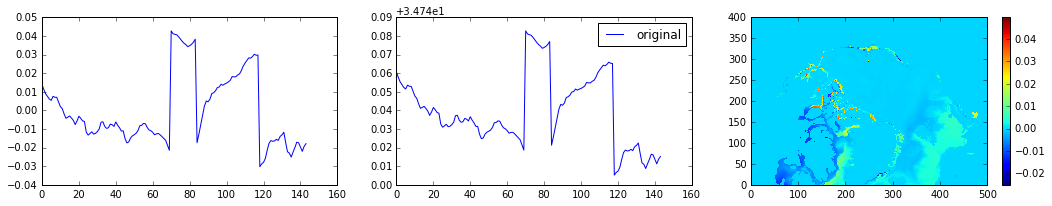

In [15]:
detrended,coef = detrended_data(s_iso, plotkey = 'True' )

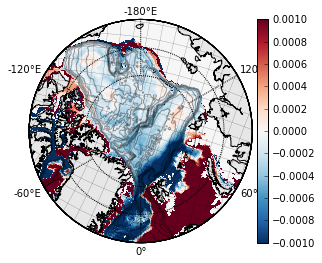

In [14]:
m,x_lon,y_lat = map.mapping(70)
m.pcolor(x_lon[:,:500],y_lat[:,:500],np.ma.masked_invalid(coef[:,:]),vmin=-0.001,vmax=0.001,cmap='RdBu_r')
m.colorbar()
m.contour(x_lon[:,:500],y_lat[:,:500],bathy,colors='k',alpha=0.2)

In [19]:
from ArcticTools import EOF
import importlib as imp

imp.reload(EOF)

<module 'ArcticTools.EOF' from '/ocean/xiaoxiny/research/tools/ArcticTools/EOF.py'>

### use the detrend data for EOF

In [20]:
deseanonal = EOF.seasonal_decomp3d(detrended)
EOFs, PC, expvar = EOF.EOF(deseanonal)

/ocean/xiaoxiny/research/tools/ArcticTools/EOF.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  eof[i, :] = np.squeeze(E[:, i]).T
/ocean/xiaoxiny/research/tools/ArcticTools/EOF.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  PC[i, :]  = np.squeeze(Z[i, :])


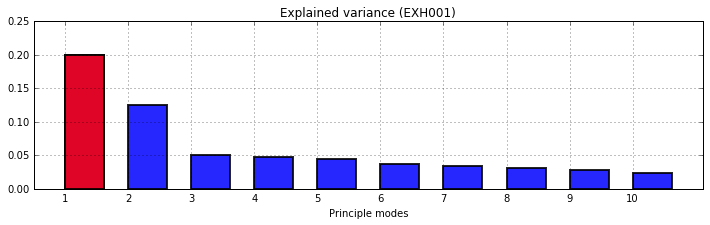

In [21]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color = 'r',label='The loading mode of AO')
ax.set_xticks(np.arange(1, 11))
#LG = ax.legend(numpoints=1, bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
#[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance (EXH001)', fontsize=12)

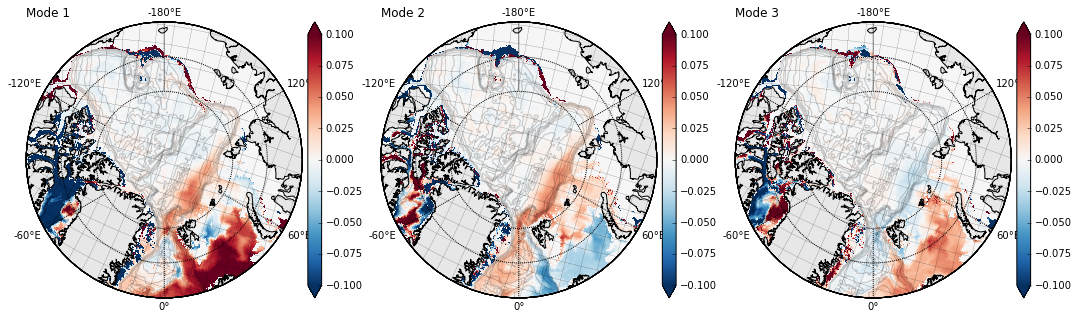

In [25]:
fig = plt.figure(figsize = (18,5))
plt.subplot(131)
m,x_lon, y_lat = map.mapping(70)
CS = m.pcolor(x_lon[:,:500], y_lat[:,:500], -EOFs[:, :, 0], cmap='RdBu_r',vmin=-0.1,vmax=0.1)
m.colorbar(extend='both')
plt.title('Mode 1',loc='left')
plt.subplot(132)
m,x_lon, y_lat = map.mapping(70)
CS = m.pcolor(x_lon[:,:500], y_lat[:,:500], -EOFs[:, :, 1], cmap='RdBu_r',vmin=-0.1,vmax=0.1)
m.colorbar(extend='both')
plt.title('Mode 2',loc='left')
plt.subplot(133)
m,x_lon, y_lat = map.mapping(70)
CS = m.pcolor(x_lon[:,:500], y_lat[:,:500], EOFs[:, :, 2], cmap='RdBu_r',vmin=-0.1,vmax=0.1)
m.colorbar(extend='both')
plt.title('Mode 3',loc='left')

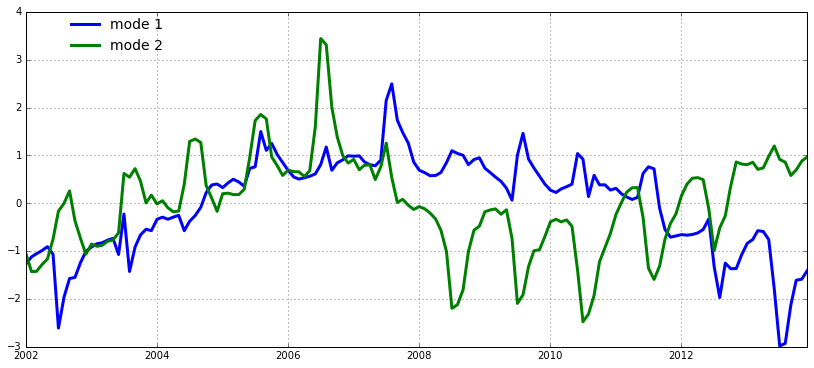

In [27]:
import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

fig = plt.figure(figsize=(14, 6))

ax = fig.gca(); ax.grid()
ax.plot(date_list, -PC[0, :], '-',  lw=3, label='mode 1')
ax.plot(date_list, -PC[1, :], '-', lw=3, label='mode 2')
#ax.plot(date_list, PC[0, :]+PC[1, :], '-', lw=3, label='mode 1 + mode 2')
#ax.plot(date_list, PC[2, :], '-',  lw=3, label='mode 3')
#ax.plot(date_list, PC[3, :], '-', lw=3, label='mode 4')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)

# Method 2: What if I keep the linear trend?

In [28]:
s_iso.shape

(144, 400, 500)

In [16]:
from ArcticTools import EOF
smean= EOF.seasonal_mean(s_iso)

### the monthly-mean I remove

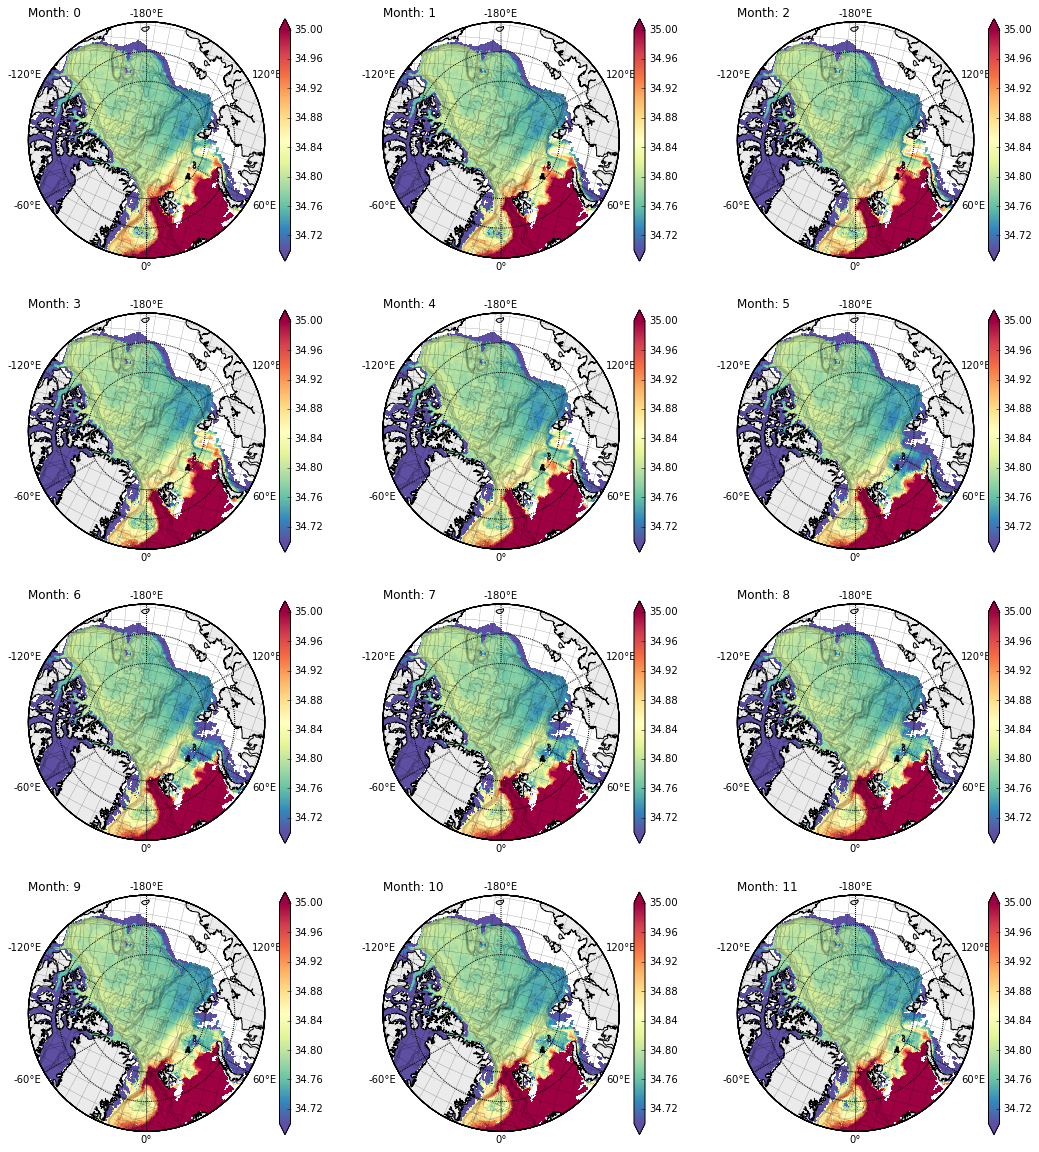

In [17]:
fig,axes = plt.subplots(4,3,figsize =(18,20))

for i,ax in zip (range (12), axes.flat):
    m,x_lon, y_lat = map.mapping(70,ax = ax)
    x_lon = x_lon[:,:500]
    y_lat = y_lat[:,:500]
    CS = m.pcolor(x_lon, y_lat, np.ma.masked_where(smean[i, :, :]==0,smean[i,:,:]), cmap='Spectral_r',vmin=34.7,vmax=35)
    plt.colorbar(CS, extend='both',ax = ax)
    ax.set_title('Month: %s'%i,loc='left')

In [29]:
deseanonal = EOF.seasonal_decomp3d(s_iso)
deseanonal.shape
#EOFs, PC, expvar = EOF.EOF(deseanonal)

(400, 500, 144)

In [30]:
EOFs, PC, expvar = EOF.EOF(deseanonal)

/ocean/xiaoxiny/research/tools/ArcticTools/EOF.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  eof[i, :] = np.squeeze(E[:, i]).T
/ocean/xiaoxiny/research/tools/ArcticTools/EOF.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  PC[i, :]  = np.squeeze(Z[i, :])


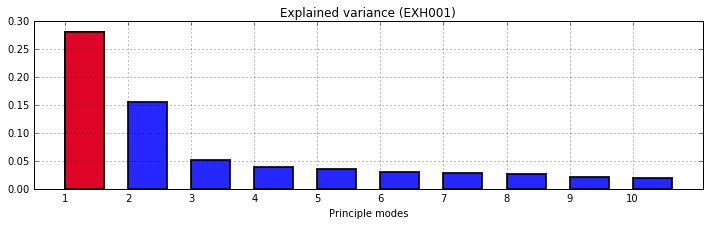

In [33]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color = 'r',label='The loading mode of AO')
ax.set_xticks(np.arange(1, 11))
#LG = ax.legend(numpoints=1, bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
#[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance (EXH001)', fontsize=12)

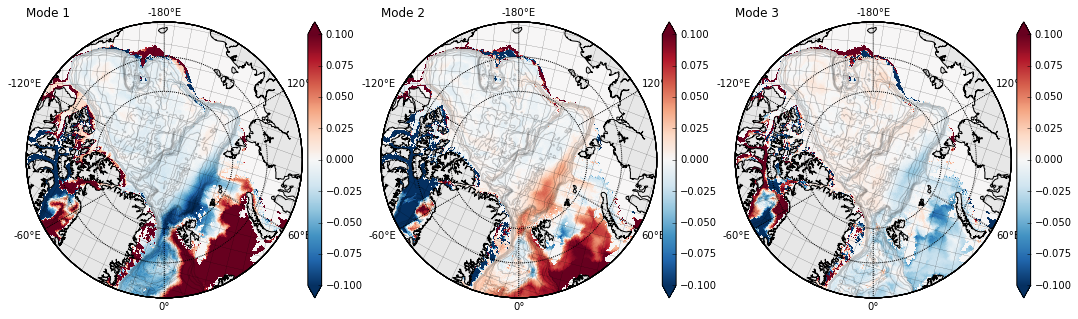

In [31]:
fig = plt.figure(figsize = (18,5))
plt.subplot(131)
m,x_lon, y_lat = map.mapping(70)
CS = m.pcolor(x_lon[:,:500], y_lat[:,:500], -EOFs[:, :, 0], cmap='RdBu_r',vmin=-0.1,vmax=0.1)
m.colorbar(extend='both')
plt.title('Mode 1',loc='left')
plt.subplot(132)
m,x_lon, y_lat = map.mapping(70)
CS = m.pcolor(x_lon[:,:500], y_lat[:,:500], -EOFs[:, :, 1], cmap='RdBu_r',vmin=-0.1,vmax=0.1)
m.colorbar(extend='both')
plt.title('Mode 2',loc='left')
plt.subplot(133)
m,x_lon, y_lat = map.mapping(70)
CS = m.pcolor(x_lon[:,:500], y_lat[:,:500], EOFs[:, :, 2], cmap='RdBu_r',vmin=-0.1,vmax=0.1)
m.colorbar(extend='both')
plt.title('Mode 3',loc='left')

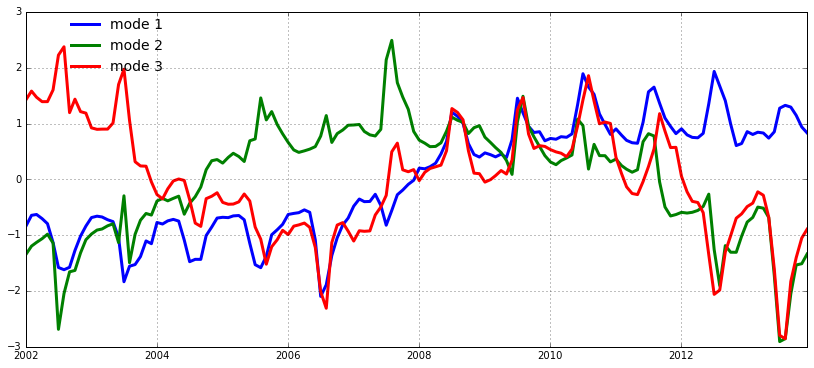

In [34]:
import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

fig = plt.figure(figsize=(14, 6))

ax = fig.gca(); ax.grid()
ax.plot(date_list, -PC[0, :], '-',  lw=3, label='mode 1')
ax.plot(date_list, -PC[1, :], '-', lw=3, label='mode 2')
#ax.plot(date_list, PC[0, :]+PC[1, :], '-', lw=3, label='mode 1 + mode 2')
ax.plot(date_list, PC[2, :], '-',  lw=3, label='mode 3')
#ax.plot(date_list, PC[3, :], '-', lw=3, label='mode 4')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)